In [1]:
import os, sys
from tqdm import trange, tqdm

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy


import torch
from torch import nn
from torch.autograd.functional import jacobian


source = "/home/loek/projects/rnn/source"
sys.path.append(source)


from data import seq_data, grid_data
from preprocessing import OneHot
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import ActivationsAnimation
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation
from data_analysis.visualization.publication import pub_show

from model import Model

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

device = torch.device("cpu")

GPU is available


In [2]:
## Load settings
settings = "deep"

(nonlinearity, gain, lr, P, L, n_epochs) = (
    pd.read_csv("model settings/rnn.txt", sep=" ", header=0).loc[settings].to_numpy()
)

In [3]:
## Generate data
symbols = [0, 1]
encoding = OneHot(symbols)
xor_problem = lambda seq: np.sum(seq) % 2
par_3_problem = lambda seq: int(np.sum(seq) % 3 == 2)

problem = xor_problem

N = 15

train_datasets = [
    seq_data(device, problem, encoding, seq_len=1, n_datapoints=N),
    seq_data(device, problem, encoding, seq_len=2, n_datapoints=N),
    seq_data(device, problem, encoding, seq_len=3, n_datapoints=N),
    seq_data(device, problem, encoding, seq_len=4, n_datapoints=N),
    seq_data(device, problem, encoding, seq_len=5, n_datapoints=N),
    # seq_data(device, problem, encoding, seq_len=6, n_datapoints=N),
    # seq_data(device, problem, encoding, seq_len=7, n_datapoints=N),
    # seq_data(device, problem, encoding, seq_len=8, n_datapoints=N),
    # seq_data(device, problem, encoding, seq_len=9, n_datapoints=N),
]

val_dataset = [seq_data(device, problem, encoding, n_datapoints=50, seq_len=10)]
tracked_datasets = val_dataset + train_datasets


grid = grid_data(device, dim=2, output_dim=2, n=20, bounds=(-1, 1))

In [4]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=2,
    output_size=2,
    hidden_dim=P,
    n_layers=L,
    device=device,
    nonlinearity=nonlinearity,
    gain=gain,
    # output_noise=0.01,
)

## TODO: Try starting with large weights

In [5]:
import scipy.spatial as spatial


def dir_to_closest(X: pd.DataFrame):
    """Compute vectors from the closest vector to each vector."""
    dist = spatial.distance_matrix(X, X)
    dist[dist == 0] = np.inf
    closest = np.argmin(dist, axis=1)
    closest_loc = X.to_numpy()[closest]
    closest_vecs = X - closest_loc
    return closest_vecs


def track_function(inputs):
    # hidden_act = model(inputs)[0].detach().numpy()
    # hidden = pd.DataFrame(hidden_act, index=labels)
    # d = dir_to_closest(hidden)  # Not normalized
    grad = jacobian(lambda x: model(x)[0], inputs)
    # print(grad.shape)
    # print("Expect only n_datapoints, output_dim, input_dim")
    # Need to think about with respect to what we take derivative of.
    # print(np.linalg.det(grad))

    # theta = np.tensordot(grad, d, axes=(1, 1))
    # print(theta.shape)

    dets = torch.Tensor(
        [
            np.sum(
                [
                    torch.det(grad[input, :, input, char, :])
                    for char in range(grad.shape[3])
                ]
            )
            for input in range(grad.shape[0])
        ]
    )
    return dets


class WeightChangeTracker(Tracker):
    """Tracks how much weights have changed in the last epoch."""

    def __init__(self, model):
        self.last_weights = None
        self.model = model
        super().__init__()

    def track(self, *args):
        new_weights = [
            torch.Tensor(params[1]).clone() for params in self.model.named_parameters()
        ]

        change = 0.0
        if self.last_weights is not None:
            old_weights = self.last_weights
            for parameter_new, parameter_old in zip(new_weights, old_weights):
                change += float(torch.norm(parameter_new - parameter_old))
        self._trace.append(pd.DataFrame([change], ["Weight change"]))

        self.last_weights = new_weights

In [6]:
## Setup compiler
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.01)
compiler = Compiler(model, criterion, optimizer)
initial_hidden = model.init_hidden(batch_size=1)[-1]
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model,
        lambda inputs: model(inputs)[1][-1],
        tracked_datasets,
        initial=lambda: initial_hidden,
    ),
    "output": ActivationTracker(
        model, lambda inputs: model(inputs)[0], tracked_datasets
    ),
    # "output_grad": ActivationTracker(
    #     model, lambda inputs: jacobian(lambda x: model(x)[0], inputs)
    # ),
    # "theta": ActivationTracker(model, track_function),
    "weight change": WeightChangeTracker(model),
}

In [7]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=1000
)

Training:  39%|███▊      | 1543/4000 [01:24<02:13, 18.36steps/s, train_loss=0.08452, val_loss=0.40054]


KeyboardInterrupt: 

Computing automata: 100%|██████████| 1543/1543 [00:04<00:00, 311.82it/s]
/home/loek/projects/rnn/source/utils/dataframes.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with float32, please explicitly cast to a compatible dtype first.
  label.loc[index] = index
/home/loek/projects/rnn/source/utils/dataframes.py:43: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '1' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  label.loc[index] = index


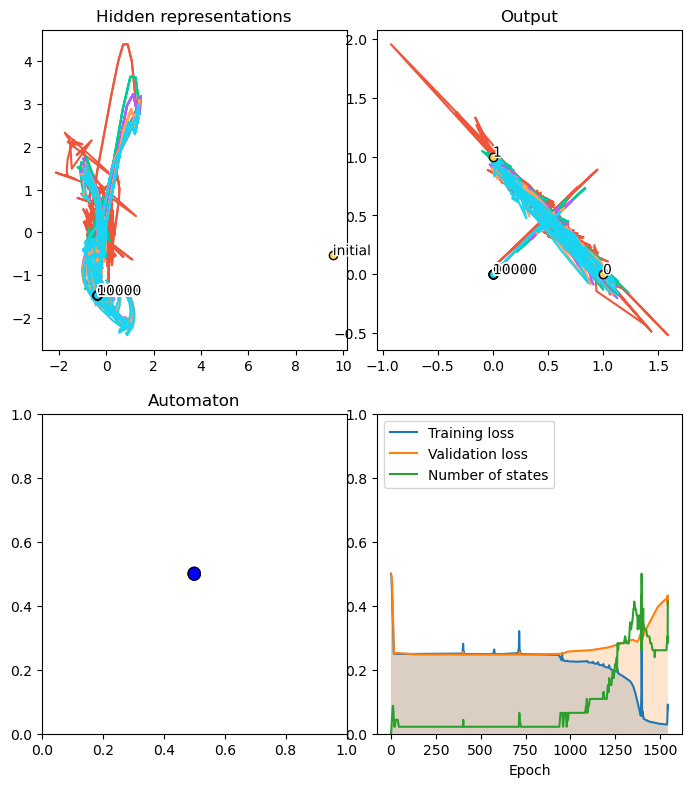

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

In [8]:
mod = 1

## Visualize automaton dynamics
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch >= 0"
query = f"Epoch % {mod} == 0"
query += "and (Dataset != 0)"
query += "and (Dataset <= 5)"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

epochs = list(set(data_hid.index.get_level_values("Epoch")))
epochs.sort()

std = float(np.linalg.norm(data_hid.std()))

automaton_history = to_automaton_history(
    data_hid, data_output, merge_distance=0.2 * std
)

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()

n_states = np.array([len(automaton.states) for automaton in automaton_history])

weight_change = compiler.trackers["weight change"].get_trace().to_numpy().reshape(-1)

animation = SliderAnimation(
    {
        "Hidden representations": ActivationsAnimation(data_hid, transform="PCA"),
        "Output": ActivationsAnimation(
            data_output, transform="none", fixed_points=encoding.encoding
        ),
        "Automaton": AutomatonAnimation(automaton_history),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={
                "Number of states": n_states,
                # "average distance": av_distances,
                # "theta": theta,
                # "weight change": weight_change,
                # "state changes": n_state_changes,
            },
            # x_bounds=(0, 800),
            y_bounds=(0, 1),
        ),
    },
    parameters=epochs,
    parameter_name="Epoch",
    fig_size=4,
)


# TODO Plot map A(h)
# TODO Plot pairwise distances
# TODO Plot total theta

In [ ]:
raise NotImplementedError

NotImplementedError: 

In [ ]:
# animation.to_gif("animation", step_size=int(len(train_loss) / 1000))

In [ ]:
## Compute d

data_hid = compiler.trackers["hidden"].get_trace()
hid = data_hid.loc[0]


av_distances = []
for epoch in range(n_epochs):
    vecs = dir_to_closest(data_hid.loc[epoch])
    av_distance = np.mean([np.sqrt(np.dot(vec, vec)) for vec in vecs.to_numpy()])
    av_distances.append(av_distance)

(array([247., 104., 124.,  58., 142., 220., 294., 216., 132., 234., 330.,
        384., 378., 272., 208., 314., 392., 522., 538., 606., 870., 772.,
        532., 486., 314., 190.,  66.,  20.,  36.,  24.]),
 array([0.        , 0.32351956, 0.64703911, 0.97055867, 1.29407823,
        1.61759779, 1.94111734, 2.2646369 , 2.58815646, 2.91167602,
        3.23519557, 3.55871513, 3.88223469, 4.20575425, 4.5292738 ,
        4.85279336, 5.17631292, 5.49983247, 5.82335203, 6.14687159,
        6.47039115, 6.7939107 , 7.11743026, 7.44094982, 7.76446938,
        8.08798893, 8.41150849, 8.73502805, 9.05854761, 9.38206716,
        9.70558672]),
 <BarContainer object of 30 artists>)

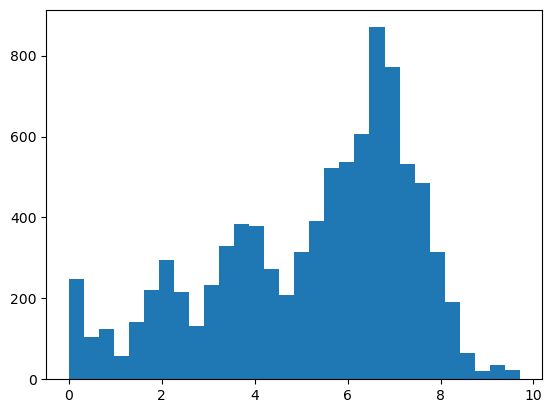

In [ ]:
hs = data_hid.query(f"Epoch == {n_epochs-1}")
plt.hist(spatial.distance_matrix(hs, hs).ravel(), bins=30)

In [ ]:
cutoff = 1


def fraction_merged(hs):
    # Find nearest points
    inputs = hs.index.get_level_values("Input")
    dist = spatial.distance_matrix(hs, hs)
    dist[dist == 0] = np.inf

    # Count fraction same output
    count_same = 0
    count_diff = 0
    count_same_merged = 0
    count_diff_merged = 0
    for i, distances in enumerate(dist):
        for j, dist in enumerate(distances):
            input_1, input_2 = inputs[i], inputs[j]
            if input_1 != "initial" and input_2 != "initial":
                output_1 = problem([int(x) for x in input_1])
                output_2 = problem([int(x) for x in input_2])
                if output_1 == output_2:
                    count_same += 1
                else:
                    count_diff += 1
                if dist < cutoff:
                    if output_1 == output_2:
                        count_same_merged += 1
                    else:
                        count_diff_merged += 1

    same_fraction = count_same_merged / count_same
    diff_fraction = count_diff_merged / count_diff
    return same_fraction, diff_fraction


n_same, n_diff = [], []
epochs = data_hid.index.unique(level="Epoch")
for epoch in tqdm(epochs):
    hs = data_hid.query(f"Epoch == {epoch}")
    same_fraction, diff_fraction = fraction_merged(hs)
    n_same.append(same_fraction)
    n_diff.append(diff_fraction)

plt.plot(train_loss, label="Training loss")
plt.plot(val_loss, label="Validation loss")
plt.plot(n_same, label="Merged pairs w. same output")
plt.plot(n_diff, label="Merged pairs w. different output")
plt.ylabel("Count")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.legend(loc="upper right")
plt.show()

In [ ]:
def fraction_nearest_same(hs):
    # Find nearest points
    inputs = hs.index.get_level_values("Input")
    dist = spatial.distance_matrix(hs, hs)
    dist[dist == 0] = np.inf
    closest = np.argmin(dist, axis=1)

    # Count fraction same output
    count_same = 0
    for i, j in enumerate(closest):
        input_1, input_2 = inputs[i], inputs[j]
        if input_1 != "initial" and input_2 != "initial":
            output_1 = problem([int(x) for x in input_1])
            output_2 = problem([int(x) for x in input_2])
            if output_1 == output_2:
                count_same += 1
    count_same = count_same / len(inputs)
    return count_same


fractions = []
epochs = data_hid.index.unique(level="Epoch")
for epoch in tqdm(epochs):
    hs = data_hid.query(f"Epoch == {epoch}")
    fractions.append(fraction_nearest_same(hs))

plt.plot(fractions)
plt.ylabel("Fraction nearest pairs same output")
plt.xlabel("Epoch")
plt.ylim(0, 1)
plt.show()

 73%|███████▎  | 2176/3000 [00:17<00:06, 121.42it/s]


KeyboardInterrupt: 

In [ ]:
## test

import torch.utils.data as data

dataset = train_datasets[3]
trainloader = data.DataLoader(dataset, batch_size=len(dataset), shuffle=False)
for batch in trainloader:
    inputs, outputs = batch

    # Get labels
    labels = []
    for input in inputs:
        try:
            decoding = model.encoding.decode(input.cpu())
            label = "".join(str(int(char)) for char in decoding)
        except KeyError:
            label = tuple(np.squeeze(input.cpu()).numpy())
        labels.append(label)


grad = jacobian(lambda x: model(x)[0], inputs)

dets = torch.Tensor(
    [
        np.sum(
            [
                torch.abs(torch.det(grad[input, :, input, char, :]))
                for char in range(grad.shape[3])
            ]
        )
        for input in range(grad.shape[0])
    ]
)

act_this_dataset = dets
act_this_dataset = torch.squeeze(act_this_dataset).cpu().detach().numpy()
act_this_dataset = pd.DataFrame(act_this_dataset, labels)
act_this_dataset

,0
0010,0.044074
0000,0.071009
0111,0.048175
0001,0.008482
1001,0.036352
1101,0.026557
1110,0.005708
1111,0.021661
0110,0.034670
1100,0.024409


100%|██████████| 100/100 [00:00<00:00, 173.70it/s]


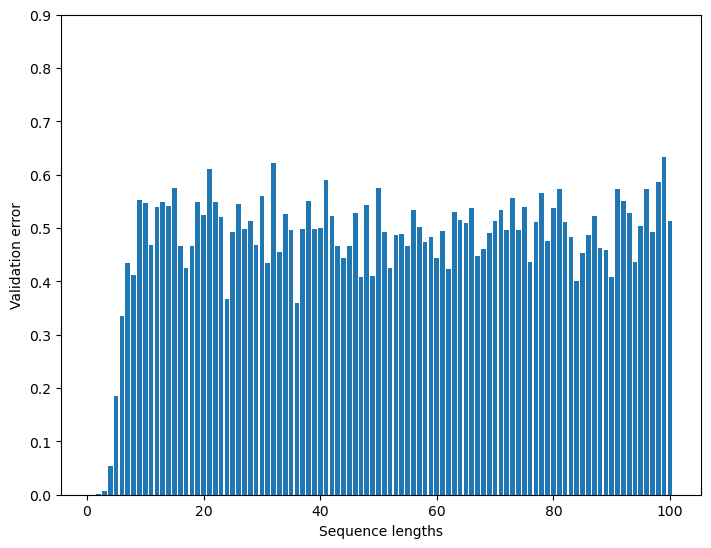

In [ ]:
## Check for generalization
N = 100
val_data = []
for n in trange(1, N + 1):
    val_data.append(seq_data(device, problem, encoding, n_datapoints=100, seq_len=n))
val_err = compiler.validation(val_data).to_numpy()[:, 0]

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.bar(np.arange(1, N + 1), val_err)
ax.set_xlabel("Sequence lengths")
ax.set_ylabel("Validation error")
ax.set_yticks(np.arange(0, 1, 0.1))
plt.show()

In [ ]:
## Make predictions


def predict(model, sequence):
    input = torch.from_numpy(np.array([encoding(sequence)], dtype=np.float32)).to(
        device
    )
    out, hidden = model(input)
    prediction = out.cpu().detach().numpy()
    return prediction


test_seq = [0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0]
print(f"Prediction: {predict(model, test_seq)}, True output: {problem(test_seq)}")

Prediction: [[ 0.9055616 -0.2686588]], True output: 1
